In [38]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta

# Function to fetch intraday data for a given date range
def fetch_intraday_data(ticker_symbol, start_date, end_date):
    try:
        return yf.download(ticker_symbol, start=start_date, end=end_date, interval="1m")
    except Exception as e:
        print(f"Failed to download data for {ticker_symbol}: {e}")
        return None

# Define the ticker symbol and date range
ticker_symbol = "TSM"
end_date = datetime.now().date()
start_date = end_date - timedelta(days=30)

# Initialize a list to store stock data chunks
stock_data_chunks = []

# Download intraday data in chunks of 7 days
while start_date < end_date:
    next_date = start_date + timedelta(days=7)
    if next_date > end_date:
        next_date = end_date
    stock_data_chunk = fetch_intraday_data(ticker_symbol, start_date, next_date)
    if stock_data_chunk is not None:
        stock_data_chunks.append(stock_data_chunk)
    start_date = next_date

# Plot intraday price per minute for each day within each chunk
for stock_data_chunk in stock_data_chunks:
    
    if not stock_data_chunk.empty:
        for day, data in stock_data_chunk.groupby(stock_data_chunk.index.date):
            plt.figure()
            plt.plot(data.index, data["Close"])
            plt.xlabel("Time")
            plt.ylabel("Price")
            plt.title("Intraday Price per Minute of " + ticker_symbol + " - " + str(day))
            plt.show()
    else:
        print(f"No data available for plotting in this chunk.")


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['TSM']: Exception('%ticker%: 1m data not available for startTime=1709355600 and endTime=1709960400. The requested range must be within the last 30 days.')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['TSM']: Exception('%ticker%: No price data found, symbol may be delisted (1m 2024-03-30 -> 2024-04-01)')


No data available for plotting in this chunk.
No data available for plotting in this chunk.


In [14]:
import boto3
from botocore.config import Config

# Initialize a session using your credentials
session = boto3.Session(
   aws_access_key_id='fcfedc12-19c7-4283-89b4-3d6144865bf5',
   aws_secret_access_key='DTc8n47jA_nApfGqD4aqKv9ntIHFOj0U',
)

# Create a client with your session and specify the endpoint
s3 = session.client(
   's3',
   endpoint_url='https://files.polygon.io',
   config=Config(signature_version='s3v4'),
)

# List Example
# Initialize a paginator for listing objects
paginator = s3.get_paginator('list_objects_v2')

# Choose the appropriate prefix depending on the data you need:
# - 'global_crypto' for global cryptocurrency data
# - 'global_forex' for global forex data
# - 'us_indices' for US indices data
# - 'us_options_opra' for US options (OPRA) data
# - 'us_stocks_sip' for US stocks (SIP) data
prefix = 'us_stocks_sip'  # Example: Change this prefix to match your data need

# List objects using the selected prefix
print("List of files:")
res = []
for page in paginator.paginate(Bucket='flatfiles', Prefix=prefix):
    for obj in page['Contents']:
        # print(obj['Key'])
        res.append(obj['Key'])


List of files:
20656


In [39]:
aws s3 ls s3://flatfiles/us_stocks_sip/minute_aggs_v1/2024/ --endpoint-url https://files.polygon.io --profile polygon

aws s3 cp s3://flatfiles/us_stocks_sip/minute_aggs_v1/2024/03/ ./polygon_data/minute_aggs/ --endpoint-url https://files.polygon.io --profile polygon

aws s3 cp s3://flatfiles/us_stocks_sip/minute_aggs_v1/2023/ ./polygon_data/minute_aggs/ --recursive --endpoint-url https://files.polygon.io --profile polygon

In [33]:
pd.set_option('display.max_columns', None)

# Set option to display all rows
pd.set_option('display.max_rows', None)

# ticker = 'AAPL'
# ticker = 'FNV'

ticker_df = df[df['ticker'] == ticker]
print(len(ticker_df))
ticker_df

In [37]:
import pandas as pd
from datetime import datetime, timedelta

tickers = ['MSFT', 'NVDA']
path = "/Users/brandon/Documents/polygon_data/minute_aggs/2023/01/2023-01-03.csv.gz"
df = pd.read_csv(path)

In [40]:
import os
import glob
import gzip
import polars as pl
from concurrent.futures import ThreadPoolExecutor

# Specify the directory containing the data files
data_dir = "/Users/brandon/Documents/polygon_data/minute_aggs/"

# Specify the ticker to filter records
# ticker = "AAPL"
ticker = "NVDA"

# Create a function to process each file
def process_file(file_path):
    # Read the data file into a DataFrame
    with gzip.open(file_path, 'rb') as f:
        df = pl.read_csv(f)
    
    # Filter records for the specified ticker
    df_filtered = df.filter(df['ticker'] == ticker)
    
    return df_filtered

# Create a dictionary to store monthly dataframes
monthly_dfs = {}

# Specify the output directory
output_dir = f"/Users/brandon/Documents/stonk_bot_data/{ticker}/"
os.makedirs(output_dir, exist_ok=True)

# Function to process files for a given year and month
def process_month(year, month):
    # Construct the path to the month directory
    month_dir = os.path.join(data_dir, str(year), "{:02d}".format(month))
    
    # Check if the month directory exists
    if not os.path.exists(month_dir):
        print(f"No data found for {year}-{month:02d}")
        return
    
    # Iterate over files in the month directory
    for file in os.listdir(month_dir):
        if file.endswith(".csv.gz"):
            file_path = os.path.join(month_dir, file)
            
            # Process the file and get the DataFrame
            df_filtered = process_file(file_path)
            
            # Get the year and month for the output file name
            year_month = f"{year}-{month:02d}"
            
            # Append the filtered DataFrame to the monthly dataframe
            if year_month not in monthly_dfs:
                monthly_dfs[year_month] = df_filtered
            else:
                monthly_dfs[year_month] = monthly_dfs[year_month].extend(df_filtered)
            
            # Print the loaded file and the output path
            print(f"Loaded {file_path}")
            output_file = os.path.join(output_dir, f"{year_month}_{ticker}.csv")
            print(f"Output path: {output_file}")

# Use ThreadPoolExecutor to parallelize processing
with ThreadPoolExecutor(max_workers=8) as executor:
    # Loop through each year from 2019 to 2020
    for year in range(2019, 2025):
        # Loop through each month
        for month in range(1, 13):
            # Submit each month for processing
            executor.submit(process_month, year, month)

# Output the combined monthly DataFrames to files
for year_month, df in monthly_dfs.items():
    output_file = os.path.join(output_dir, f"{year_month}_{ticker}.csv")
    df.write_csv(output_file)
    print(f"Saved {output_file}")


In [45]:
import os
import polars as pl
import glob
import gzip
from concurrent.futures import ThreadPoolExecutor, as_completed

# Function to process a single file
def process_file(file_path, ticker, year_month, output_dir):
    with gzip.open(file_path, 'rb') as f:
        df = pl.read_csv(f)
    df_filtered = df.filter(df['ticker'] == ticker)
    output_file = os.path.join(output_dir, f"{year_month}_{ticker}.csv")
    # Since writing to the same file from multiple threads is not safe, we return the filtered DataFrame
    return df_filtered, output_file

# Specify the directory containing the data files and other parameters
data_dir = "/Users/brandon/Documents/polygon_data/minute_aggs/"
ticker = "NVDA"
output_dir = f"/Users/brandon/Documents/stonk_bot_data/{ticker}/" 
os.makedirs(output_dir, exist_ok=True)

# Create a dictionary to store monthly dataframes
monthly_dfs = {}

# Configure the maximum number of threads to use
max_workers = 8

# Loop through each year from 2019 to 2025
for year in range(2024, 2025):
    for month in range(1, 13):
        month_dir = os.path.join(data_dir, str(year), "{:02d}".format(month))
        if not os.path.exists(month_dir):
            print(f"No data found for {year}-{month:02d}")
            continue
        
        # Collect all file paths to process
        file_paths = [os.path.join(month_dir, file) for file in os.listdir(month_dir) if file.endswith(".csv.gz")]
        
        # Use ThreadPoolExecutor to process files in parallel
        with ThreadPoolExecutor(max_workers=max_workers) as executor:
            # Create a future for each file
            futures = [executor.submit(process_file, file_path, ticker, f"{year}-{month:02d}", output_dir) for file_path in file_paths]
            
            # As futures complete, process their results
            for future in as_completed(futures):
                df_filtered, output_file = future.result()
                # Append or extend the DataFrame in monthly_dfs
                year_month = os.path.basename(output_file).replace(f"_{ticker}.csv", "")
                if year_month not in monthly_dfs:
                    monthly_dfs[year_month] = df_filtered
                else:
                    monthly_dfs[year_month] = monthly_dfs[year_month].extend(df_filtered)
                print(f"Processed {output_file}")

# Output the combined monthly DataFrames to files
for year_month, df in monthly_dfs.items():
    output_file = os.path.join(output_dir, f"{year_month}_{ticker}.csv")
    df.write_csv(output_file)
    print(f"Saved {output_file}")


/var/folders/02/rhqbxtqx23ggj00yk4ct6dp40000gn/T/ipykernel_81706/1811528340.py:10: UserWarning:

Polars found a filename. Ensure you pass a path to the file instead of a python file object when possible for best performance.



In [53]:
import os
import polars as pl
import datetime as dt
from polars import Config

pl.Config.set_fmt_str_lengths(100)
pl.Config.set_tbl_rows(1000)

ticker = "NVDA"
directory_path = f"/Users/brandon/Documents/stonk_bot_data/{ticker}/"

# List all CSV files in the directory
files = [os.path.join(directory_path, file) for file in os.listdir(directory_path) if file.endswith(".csv")]

# Create an empty list to store DataFrames
dfs = []

# Read each CSV file and append its DataFrame to the list
for file in files:
    df = pl.read_csv(file)
    dfs.append(df)

# Concatenate all DataFrames into a single DataFrame
df = pl.concat(dfs).with_row_index(name='index')

# Convert window_start to Eastern Time
window_start_est = (df['window_start'] / 10**9).map_elements(
    lambda ts: dt.datetime.fromtimestamp(ts, dt.timezone.utc).astimezone(dt.timezone(dt.timedelta(hours=-5)))
)
df = df.with_columns([window_start_est.alias('window_start_est')])

# Calculate window_end as window_start + 1 minute
window_end = df['window_start'] + 60 * 10**9
df = df.with_columns([window_end.alias('window_end')])

# Convert window_end to Eastern Time
window_end_est = (df['window_end'] / 10**9).map_elements(
    lambda ts: dt.datetime.fromtimestamp(ts, dt.timezone.utc).astimezone(dt.timezone(dt.timedelta(hours=-5)))
)
df = df.with_columns([window_end_est.alias('window_end_est')])

# Define trading hours
pre_market_start = dt.time(4, 0)  # Pre-market starts at 4:00 AM
trading_start = dt.time(9, 30)
trading_end = dt.time(16, 0)

# Create flags for regular trading hours, after hours, and pre-market hours
regular_trading_hours = pl.when(
    (pl.col('window_start_est').dt.time() >= trading_start) &
    (pl.col('window_start_est').dt.time() <= trading_end)
).then(1).otherwise(0)

after_hours = pl.when(
    (pl.col('window_start_est').dt.time() > trading_end) |
    (pl.col('window_start_est').dt.time() < pre_market_start)
).then(1).otherwise(0)

pre_market_hours = pl.when(
    (pl.col('window_start_est').dt.time() >= pre_market_start) &
    (pl.col('window_start_est').dt.time() < trading_start)
).then(1).otherwise(0)

# Add the new columns to the DataFrame
df = df.with_columns([
    regular_trading_hours.alias('regular_trading_hours'),
    after_hours.alias('after_hours'),
    pre_market_hours.alias('pre_market_hours'),
    df['window_start_est'].dt.date().alias('transaction_date')
])

# Calculate traded value for each transaction
df = df.with_columns([
    (pl.col('volume') * pl.col('close')).alias('traded_value')
])

# Calculate cumulative totals within each trading session
df = df.with_columns([
    pl.col('traded_value').cum_sum().over(['ticker', 'transaction_date']).alias('daily_traded_value'),
    pl.col('volume').cum_sum().over(['ticker', 'transaction_date']).alias('daily_cumulative_volume')
])

# Calculate the VWAP for each transaction
df = df.with_columns([
    (pl.col('daily_traded_value') / pl.col('daily_cumulative_volume')).alias('daily_vwap')
])

df = df.with_columns([
    pl.col('daily_vwap').rolling_mean(window_size=2).over(["ticker"]).alias('vwap_2d'),
    pl.col('daily_vwap').rolling_mean(window_size=3).over(["ticker"]).alias('vwap_3d')
])

# Extract hour from 'window_start_est'
df = df.with_columns(pl.col('window_start_est').dt.hour().alias('hour'))

hourly_vwap_calculation = df.group_by(['ticker', 'transaction_date', 'hour']).agg([
    (pl.sum('traded_value').alias('hourly_traded_value')),
    (pl.sum('volume').alias('hourly_volume')),
    (pl.sum('traded_value') / pl.sum('volume')).alias('hourly_vwap')
])

# Merge the hourly VWAP back into the original DataFrame
df = df.join(
    hourly_vwap_calculation,
    on=['ticker', 'transaction_date', 'hour'],
    how='left'
)

df = df.sort(['ticker', 'transaction_date'])

# Define a function to calculate EMA given a series, span, and adjust flag
def ema_custom(series: pl.Series, name: str, span: int) -> pl.Series:
    alpha = 2 / (span + 1)
    ema = series.ewm_mean(com=span, adjust=False, ignore_nulls=True).alias(name)
    return ema

# Calculate EMA for 12 and 26 periods and add them to the DataFrame
df = df.with_columns(
    [
        ema_custom(df["close"], f"ema_{span}", span=span)
        for span in [12, 26]
    ]
)

# Calculate the MACD line
df = df.with_columns((pl.col("ema_12") - pl.col("ema_26")).alias("MACD_line"))

# Calculate the Signal line
df = df.with_columns(ema_custom(pl.col("MACD_line"), "signal_line", span=9))

# Calculate the distance between MACD and Signal lines
df = df.with_columns((pl.col("MACD_line") - pl.col("signal_line")).alias("MACD_Signal_distance"))

# Calculate the slope of the MACD line (current value - previous value)
df = df.with_columns(pl.col("MACD_line").diff().alias("MACD_slope"))

# Calculate the slope of the Signal line (current value - previous value)
df = df.with_columns(pl.col("signal_line").diff().alias("Signal_slope"))

# Identify MACD line crosses above Signal line (bullish signal)
df = df.with_columns(
    ((pl.col("MACD_line") > pl.col("signal_line")) & 
    (pl.col("MACD_line").shift(-1) <= pl.col("signal_line").shift(-1))).cast(pl.Int8).alias("MACD_cross_above")
)

# Identify MACD line crosses below Signal line (bearish signal)
df = df.with_columns(
    ((pl.col("MACD_line") < pl.col("signal_line")) & 
    (pl.col("MACD_line").shift(-1) >= pl.col("signal_line").shift(-1))).cast(pl.Int8).alias("MACD_cross_below")
)


# df


In [60]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
from pandas import Timestamp
import plotly.io as pio

# Settings
pd.set_option('display.max_rows', None)
# pio.renderers.default = "notebook"

# Convert the Polars DataFrame to pandas
pandas_df = df.to_pandas()
pandas_df['window_start_est'] = pd.to_datetime(pandas_df['window_start_est'])

# Filter the DataFrame to only include data within the specified window
window_start = Timestamp('2024-03-09 09:00')
window_end = Timestamp('2024-03-09 16:00')
filtered_df = pandas_df[(pandas_df['window_start_est'] >= window_start) & (pandas_df['window_start_est'] <= window_end)]

# Create a subplot with 2 rows
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.2, subplot_titles=(f' {ticker} Stock Price with 2-day and 3-day VWAP', 'MACD & Signal Line'))

# Add the candlestick chart to the first row
fig.add_trace(go.Candlestick(x=filtered_df['window_start_est'], open=filtered_df['open'], high=filtered_df['high'], low=filtered_df['low'], close=filtered_df['close']), row=1, col=1)

# Adding the 2-day VWAP to the candlestick chart
fig.add_trace(go.Scatter(x=filtered_df['window_start_est'], y=filtered_df['vwap_2d'], mode='lines', name='2-day VWAP', line=dict(width=2)), row=1, col=1)

# Adding the 3-day VWAP to the candlestick chart
fig.add_trace(go.Scatter(x=filtered_df['window_start_est'], y=filtered_df['vwap_3d'], mode='lines', name='3-day VWAP', line=dict(width=2)), row=1, col=1)

# Add MACD line to the second row
fig.add_trace(go.Scatter(x=filtered_df['window_start_est'], y=filtered_df['MACD_line'], mode='lines', name='MACD Line'), row=2, col=1)

# Add Signal line to the second row
fig.add_trace(go.Scatter(x=filtered_df['window_start_est'], y=filtered_df['signal_line'], mode='lines', name='Signal Line'), row=2, col=1)

# Updating layout for better readability
fig.update_layout(title=f'{ticker} Stock Price and Technical Indicators on 2022-03-22', xaxis_title='Time', yaxis_title='Price (USD)', legend_title_text='Indicator', xaxis_rangeslider_visible=False)

# Adjust x-axis and y-axis titles for subplots
fig.update_xaxes(title_text="Time", row=2, col=1)
fig.update_yaxes(title_text="Price (USD)", row=1, col=1)
fig.update_yaxes(title_text="MACD", row=2, col=1)

# Show the plot
pio.renderers.default = "notebook"

fig.show(renderer='browser')


In [63]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
from pandas import Timestamp
import plotly.io as pio

# Settings
pd.set_option('display.max_rows', None)
pio.renderers.default = "notebook"

# Convert the Polars DataFrame to pandas
pandas_df = df.to_pandas()
pandas_df['window_start_est'] = pd.to_datetime(pandas_df['window_start_est'])

# Filter the DataFrame to only include data within the specified window
window_start = Timestamp('2024-03-14 09:00')
window_end = Timestamp('2024-03-14 16:00')
filtered_df = pandas_df[(pandas_df['window_start_est'] >= window_start) & (pandas_df['window_start_est'] <= window_end)]

# Determine crossing points
cross_above = filtered_df[filtered_df['MACD_cross_above'] == 1]['window_start_est']
cross_below = filtered_df[filtered_df['MACD_cross_below'] == 1]['window_start_est']

# Create a subplot with 2 rows
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.2, subplot_titles=(f'{ticker} Stock Price with 2-day and 3-day VWAP', 'MACD & Signal Line'))

# Add the candlestick chart to the first row
fig.add_trace(go.Candlestick(x=filtered_df['window_start_est'], open=filtered_df['open'], high=filtered_df['high'], low=filtered_df['low'], close=filtered_df['close']), row=1, col=1)

# Adding the 2-day VWAP to the candlestick chart
fig.add_trace(go.Scatter(x=filtered_df['window_start_est'], y=filtered_df['vwap_2d'], mode='lines', name='2-day VWAP', line=dict(width=2)), row=1, col=1)

# Adding the 3-day VWAP to the candlestick chart
fig.add_trace(go.Scatter(x=filtered_df['window_start_est'], y=filtered_df['vwap_3d'], mode='lines', name='3-day VWAP', line=dict(width=2)), row=1, col=1)

# Add MACD line to the second row
fig.add_trace(go.Scatter(x=filtered_df['window_start_est'], y=filtered_df['MACD_line'], mode='lines', name='MACD Line'), row=2, col=1)

# Add Signal line to the second row
fig.add_trace(go.Scatter(x=filtered_df['window_start_est'], y=filtered_df['signal_line'], mode='lines', name='Signal Line'), row=2, col=1)

# Add vertical lines for MACD crossing above Signal line
for cross_time in cross_above:
    fig.add_vline(x=cross_time, line=dict(color="green", width=2), row='all', col=1)

# Add vertical lines for MACD crossing below Signal line
for cross_time in cross_below:
    fig.add_vline(x=cross_time, line=dict(color="red", width=2), row='all', col=1)

# Updating layout for better readability
fig.update_layout(title=f'{ticker} Stock Price and Technical Indicators on {window_start}', xaxis_title='Time', yaxis_title='Price (USD)', legend_title_text='Indicator', xaxis_rangeslider_visible=False)

# Adjust x-axis and y-axis titles for subplots
fig.update_xaxes(title_text="Time", row=2, col=1)
fig.update_yaxes(title_text="Price (USD)", row=1, col=1)
fig.update_yaxes(title_text="MACD", row=2, col=1)

# Show the plot
pio.renderers.default = "notebook"
fig.show(renderer='browser')


In [48]:
!jupyter labextension install @jupyter-widgets/jupyterlab-manager plotlywidget@4.14.3
!jupyter nbextension enable --py widgetsnbextension


(Deprecated) Installing extensions with the jupyter labextension install command is now deprecated and will be removed in a future major version of JupyterLab.

Users should manage prebuilt extensions with package managers like pip and conda, and extension authors are encouraged to distribute their extensions as prebuilt packages 
Building jupyterlab assets (production, minimized)


In [9]:
###### DAY TRADING ADDICT
import pandas as pd
import numpy as np

# Sample DataFrame
# df = pd.read_csv('your_data.csv', index_col='Date', parse_dates=True)

def calculate_moving_average(df, window=50):
    df['MA50'] = df['close'].rolling(window=window).mean()

def find_support_resistance(df):
    # This is a simplified approach. In practice, you'd look for more precise patterns.
    df['Support'] = df['Low'].rolling(window=5).min()
    df['Resistance'] = df['High'].rolling(window=5).max()

def risk_management(entry_price, stop_loss_price, risk_per_trade, account_balance):
    # Assuming risk_per_trade is a percentage of account_balance
    amount_to_risk = account_balance * (risk_per_trade / 100)
    # Assuming one point move equals $1 profit/loss
    points_to_risk = abs(entry_price - stop_loss_price)
    quantity = amount_to_risk / points_to_risk
    return quantity

calculate_moving_average(df)
find_support_resistance(df)

# Example trade calculation
entry_price = 100  # Example entry price
stop_loss_price = 95  # Example stop loss price
account_balance = 10000  # Example account balance
risk_per_trade = 1  # Risk 1% of account per trade

trade_quantity = risk_management(entry_price, stop_loss_price, risk_per_trade, account_balance)

print(f"Suggested trade quantity: {trade_quantity}")


AttributeError: 'Series' object has no attribute 'rolling'

In [66]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam

# Load your dataset
pandas_df = df.to_pandas()
df_regular_hours = pandas_df[pandas_df['regular_trading_hours'] == True]

# Assuming the data is already sorted chronologically and aggregated into 5-minute intervals

# Select your features and target
features = ['open', 'high', 'low', 'close', 'volume']
target = 'close'  # Predicting the next close price

# Generate lagged features to use past values to predict the future value
for lag in range(1, 6):  # Using the last 5 intervals
    for feature in features:
        df_regular_hours[f'{feature}_lag_{lag}'] = df_regular_hours[feature].shift(lag)

# Drop rows with NaN values due to lagging
df_regular_hours.dropna(inplace=True)

# Define features and target
X = df_regular_hours[[f'{feature}_lag_{lag}' for feature in features for lag in range(1, 6)]]
y = df_regular_hours[target]

# Split data into training and test sets (95% train, 5% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, shuffle=False)

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape input to be 3D [samples, timesteps, features] for LSTM
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 5, len(features)))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 5, len(features)))

### Step 2: Build and Train the Model

model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

### Step 3: Predict and Evaluate

# Make predictions
predictions = model.predict(X_test_scaled)

# Evaluate predictions (implement your preferred evaluation metrics)
# Example: Mean Squared Error (MSE)
mse = np.mean(np.square(y_test - predictions.flatten()))
print(f'Mean Squared Error: {mse}')


In [65]:
test_time = df_regular_hours['window_start'][-len(X_test):].reset_index(drop=True)

# Continue with your model training and prediction code

# After predicting with the model
# Combine predictions, actual values, and time into a DataFrame
comparison_df = pd.DataFrame({
    'Time': test_time,
    'Actual': y_test.reset_index(drop=True),  # Reset index to ensure alignment
    'Predicted': predictions.flatten(),  # Flatten predictions if necessary
})

# Calculate the absolute error (variance) between actual and predicted values
comparison_df['Absolute Error'] = abs(comparison_df['Actual'] - comparison_df['Predicted'])
comparison_df = comparison_df.sort_values(by='Time', ascending=True)

Reset the index of the DataFrame after sorting, if desired
comparison_df.reset_index(drop=True, inplace=True)
comparison_df

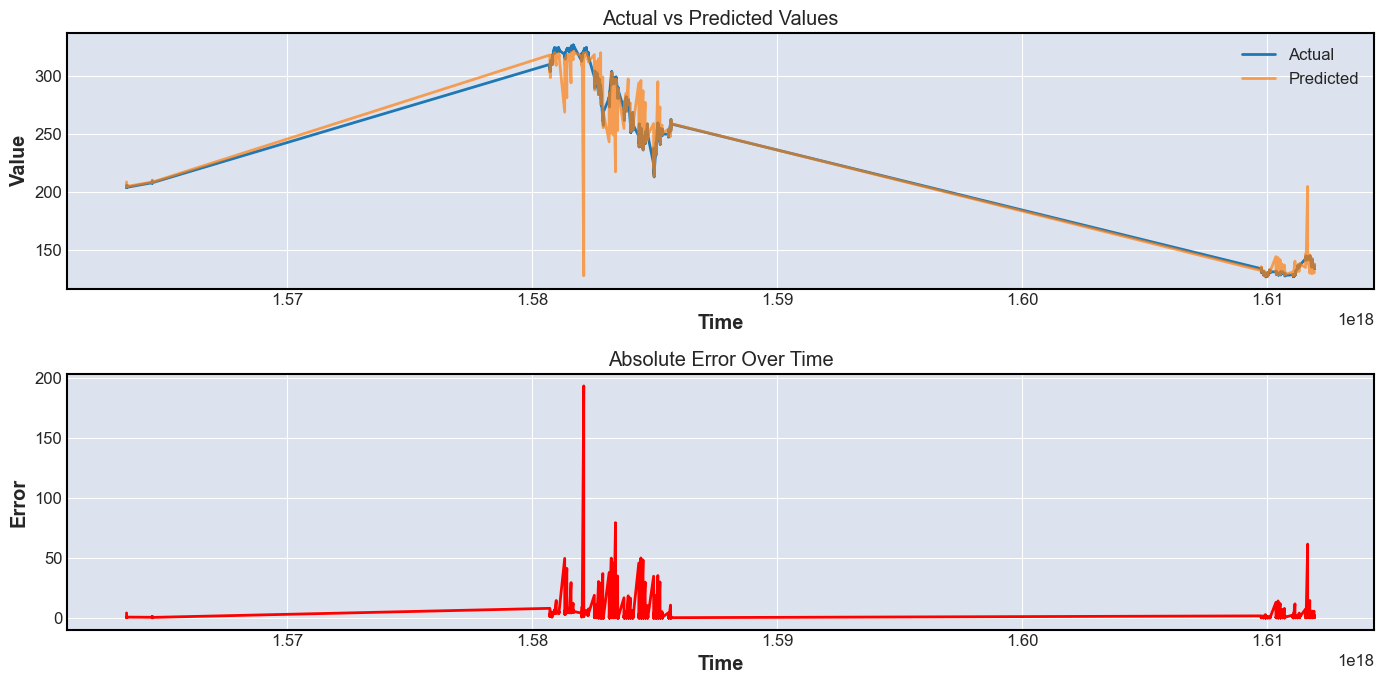

In [31]:
plt.figure(figsize=(14, 7))

# Plot actual vs. predicted values
plt.subplot(2, 1, 1)
plt.plot(comparison_df['Time'], comparison_df['Actual'], label='Actual')
plt.plot(comparison_df['Time'], comparison_df['Predicted'], label='Predicted', alpha=0.7)
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()

# Plot the absolute error over time
plt.subplot(2, 1, 2)
plt.plot(comparison_df['Time'], comparison_df['Absolute Error'], label='Absolute Error', color='red')
plt.title('Absolute Error Over Time')
plt.xlabel('Time')
plt.ylabel('Error')
plt.tight_layout()

plt.show()